# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Create a new data frame with email as index and a column containing the article interactions
df_users=pd.DataFrame(df['email'].value_counts())
df_users.rename(columns={'email':'articleInteractions'}, inplace=True)

Text(0,0.5,'Frequency')

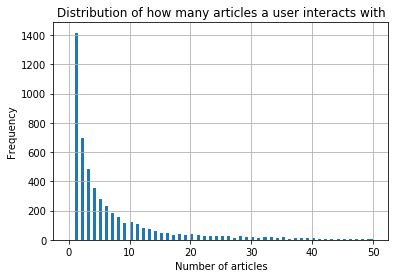

In [4]:
# Create a histogram of the number of article interactions
df_users['articleInteractions'].hist(bins=100, range=(0, 50))
plt.title("Distribution of how many articles a user interacts with")
plt.xlabel('Number of articles')
plt.ylabel('Frequency')

In [5]:
# Calculate the median of articleInteractions
df_users['articleInteractions'].median()

3.0

In [6]:
# Calculate the max value of articleInteractions
df_users['articleInteractions'].max()

364

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
df_content['article_id'].value_counts() # This shows 5 articles appearing twice

221     2
232     2
577     2
398     2
50      2
356     1
355     1
354     1
353     1
345     1
352     1
351     1
350     1
349     1
348     1
357     1
347     1
346     1
1050    1
344     1
359     1
343     1
342     1
341     1
340     1
339     1
338     1
337     1
336     1
335     1
       ..
706     1
719     1
718     1
717     1
716     1
715     1
714     1
713     1
712     1
711     1
710     1
709     1
708     1
707     1
705     1
691     1
704     1
703     1
702     1
701     1
700     1
699     1
698     1
697     1
696     1
695     1
694     1
693     1
692     1
0       1
Name: article_id, Length: 1051, dtype: int64

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content=df_content.drop_duplicates('article_id',keep='first')

In [10]:
# Check whether duplicates have been removed
df_content['article_id'].value_counts()

1050    1
360     1
358     1
357     1
356     1
355     1
354     1
353     1
352     1
351     1
350     1
349     1
348     1
347     1
346     1
345     1
344     1
343     1
342     1
341     1
340     1
339     1
338     1
337     1
336     1
335     1
334     1
333     1
332     1
331     1
       ..
706     1
719     1
718     1
717     1
716     1
715     1
714     1
713     1
712     1
711     1
710     1
709     1
708     1
707     1
705     1
691     1
704     1
703     1
702     1
701     1
700     1
699     1
698     1
697     1
696     1
695     1
694     1
693     1
692     1
0       1
Name: article_id, Length: 1051, dtype: int64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# Check the number of unique articles that have at least one interaction
df.article_id.value_counts().shape[0] # Count the number of rows in the dataframe with one row for each article with at least one interaction

714

In [12]:
# Check the number of unique articles on the IBM platform
df_content.shape[0]

1051

In [13]:
# Check the number of unique users
df.email.value_counts().shape[0] # Count the number of rows in the dataframe with one row for each user

5148

In [14]:
# Check the number of user-article interactions
df.shape[0]

45993

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
# Check most viewed article (the top-ranked one)
df.article_id.value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
1436.0    481
1271.0    473
1398.0    465
43.0      460
1351.0    457
1393.0    455
1185.0    442
1160.0    433
1354.0    426
1368.0    418
1305.0    413
1338.0    382
1336.0    379
1165.0    372
1172.0    363
151.0     352
1276.0    347
1432.0    340
1430.0    336
1052.0    330
         ... 
1208.0      2
778.0       2
1283.0      2
1135.0      2
1210.0      2
430.0       2
416.0       2
1251.0      2
1227.0      2
1230.0      2
1086.0      2
1156.0      2
1266.0      1
653.0       1
1233.0      1
1127.0      1
1092.0      1
1119.0      1
675.0       1
724.0       1
1237.0      1
1202.0      1
1344.0      1
662.0       1
1200.0      1
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # Create an empty list
    top_articles = []
    
    # Create a series ascendingly ordered by rank of article titles
    df_counts = df.title.value_counts()
    
    # Go through the first n articles and add the titles to the list
    i = 0
    while i < n:
        top_articles.append(df_counts.index[i])
        i=i+1

    # Return the top article titles from df (not df_content)    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    # Create an empty list
    top_articles = []
 
    # Create a series ascendingly ordered by rank of article ids
    df_counts = df.article_id.value_counts()

    # Go through the first n articles and add the titles to the list
    i = 0
    while i < n:
        top_articles.append(df_counts.index[i])
        i=i+1

    # Return the top article ids
    return top_articles

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# Check the number of different users
df.user_id.value_counts().shape[0]

5149

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # Check number of users in df
    number_of_users=df.user_id.value_counts().shape[0]

    # Create data frame in which the number of rows corresponds to the number of users 
    user_item = pd.DataFrame(index=range(1,number_of_users))
    
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        user_item.at[row.user_id, row.article_id]=1 # Set 1 if article has been read
    
    # Replace NaN values (article not read by user) by zeros
    user_item=user_item.fillna(0)
    
    # Return the user_item matrix 
    return user_item

user_item = create_user_item_matrix(df)

In [25]:
user_item.head()

,1430.0,1314.0,1429.0,1338.0,1276.0,1432.0,593.0,1185.0,993.0,14.0,...,1135.0,881.0,183.0,655.0,1233.0,1156.0,555.0,708.0,575.0,972.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    df_sim=pd.DataFrame(columns=['dot_product'])
    
    # Compute similarity of each user to the provided user
    
    # Iterate over all rows
    for index, row in user_item.iterrows():
        dot_product=0
        
        # Iterate over all columns
        for col_name, col_data in user_item.iteritems():
            if user_item.at[user_id, col_name]==user_item.at[index, col_name]:
                dot_product=dot_product+1 # Add 1 if position is identical
        df_sim.at[index, 'dot_product']=dot_product

    # Sort by similarity
    df_sim=df_sim.sort_values(by=['dot_product'], ascending=False)

    # Create list of just the ids
    most_similar_users = []
    for index, row in df_sim.iterrows():
        most_similar_users.append(index)
   
    # Remove the own user's id
    most_similar_users.remove(user_id)
    
    # Return a list of the users in order from most to least similar   
    return most_similar_users
        

In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 5034, 824, 253, 136, 2305, 4504, 4020, 3031, 2447]
The 5 most similar users to user 3933 are: [1, 253, 824, 5034, 136]
The 3 most similar users to user 46 are: [4201, 790, 824]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [29]:
def get_unseen_articles(my_user_id, other_user_id, user_item=user_item):
    '''
    INPUT:
    my_user_id - (int) the user id of "my" user (for which recommendations shall be made)
    other_user_id - (int) the user id of another user to get recommendations from
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids unseen by "my" user
    
    Description:
    Provides a list of the article_ids that "my" user has not seen before but the other user has
    '''
    
    # Create empty lists for article ids and article names
    article_ids=[]

    # Iterate over all columns
    for col_name, col_data in user_item.iteritems():
        
        # Add article id to the list if it has not been seen by "my" user but seen by the other user
        if user_item.at[my_user_id, col_name]==0.0 and user_item.at[other_user_id, col_name]==1.0:
            article_ids.append(col_name)
    
    return article_ids #  Return list of unseen articles


In [30]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    # Create list of just the ids
    article_names = []
    
    # Loop over input list of article ids
    i=0
    while i < len(article_ids):
        
        # Loop over all rows
        for index, row in df.iterrows():
            
            # Add article name to output list if ids fit
            if article_ids[i]==str(row.article_id):
                article_names.append(row.title)
                break # Break since it shall only be added one time
        i=i+1
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # Create empty lists for article ids and article names
    article_ids=[]
    article_names=[]

    # Iterate over all columns in user items
    for col_name, col_data in user_item.iteritems():
        
        # Add the id to article_ids list if user has seen the article
        if user_item.at[user_id, col_name]==1.0:
            article_ids.append(str(col_name))
            
            # Fetch the corresponding title and add it to the article_names list
            for index, row in df.iterrows():
                
                # Add article name to output list if ids fit
                if col_name==row.article_id:
                    article_names.append(row.title)
                    break # Break since it shall only be added one time
 
    return article_ids, article_names # Return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Create empty output list
    recs=[]
    
    # Get the list of most similar users and create an iterator for it
    most_similar_users=find_similar_users(user_id, user_item)
    most_similar_users_iterator=iter(most_similar_users)
    
    i=0 # Counter to count the number of already found recommendations
    
    # Loop as long as not all m recommendations have been found
    while True:
        
        try:
            # Get next user from the list of most similar users
            current_most_similar_user=next(most_similar_users_iterator)
        
            # Get articles unseen by "my" user but seen by the current most similar one and create an iterator for it
            unseen_articles=get_unseen_articles(user_id, current_most_similar_user)
            unseen_articles_iterator=iter(unseen_articles)
            
            while i<m:
        
                try:
                    # Get next unseen article, add it to the output list, and increment counter
                    current_unseen_article=next(unseen_articles_iterator)
                    recs.append(str(current_unseen_article))            
                    i=i+1 # Count already found articles
                
                except StopIteration:
                    break # Break if iterator has reached end of the list
            
            # Stop criterion for the loop
            if i>=m:
                 break
        
        except StopIteration:
            break # Break if iterator has reached end of the list
    
    return recs # Return your recommendations for this user_id (the list may contain less than m elements if they not exist) 

In [31]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['use spark for python to load data and run sql queries',
 '9 mistakes to avoid when starting your career in data science',
 'movie recommender system with spark machine learning',
 'analyze open data sets with spark & pixiedust',
 'announcing dsx environments in beta!',
 'the nurse assignment problem',
 'this week in data science (may 30, 2017)',
 'customer demographics and sales',
 'self-service data preparation with ibm data refinery',
 'ml optimization using cognitive assistant']

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [33]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Create neighbors_df with index copied from user_item
    neighbors_df = user_item.index.to_frame()
    neighbors_df['similarity'] = 0
    neighbors_df['num_interactions'] = 0
    neighbors_df=neighbors_df.rename(columns={0: "neighbor_id"})

    # Iterate over all rows
    for index, row in user_item.iterrows():
        similarity=0
        num_interactions=0
        
        # Iterate over all columns
        for col_name, col_data in user_item.iteritems():
            if user_item.at[user_id, col_name]==1.0 and user_item.at[index, col_name]==1.0:
                similarity=similarity+1
            if user_item.at[index, col_name]==1.0:
                num_interactions=num_interactions+1
                
        # Set similarity and interaction values for each user
        neighbors_df.at[index, 'similarity']=similarity
        neighbors_df.at[index, 'num_interactions']=num_interactions        
        
    neighbors_df=neighbors_df.sort_values(['similarity', 'num_interactions'], ascending = (False, False))
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Create empty output list
    recs=[]
    rec_names=[]
    
    # Get data frame of top sorted users
    neighbors_df=get_top_sorted_users(user_id, df=df, user_item=user_item)
        
    i=0 # Counter to count the number of already found recommendations
    
    # Iterate over all rows of the data frame of top sorted users
    for index, row in neighbors_df.iterrows():
        if row.neighbor_id != user_id: # This skips the own user which appears also in the data frame
            
            # Get articles unseen by "my" user but seen by the current neighbor user and create an iterator for it
            unseen_articles=get_unseen_articles(user_id, row.neighbor_id)
            unseen_articles_iterator=iter(unseen_articles)
    
            while i<m:
        
                try:
                    # Get next unseen article, add it to the output list, and increment counter
                    current_unseen_article=next(unseen_articles_iterator)
                    recs.append(str(current_unseen_article))
                    
                    # Iterate over df to find the article name which corresponds to the id
                    for index, row in df.iterrows():
            
                        # Add article name to output list if ids fit
                        if current_unseen_article==row.article_id:
                            rec_names.append(row.title)
                            break # Break since it shall only be added one time
                    
                    i=i+1 # Count already found articles
                
                except StopIteration:
                    break # Break if iterator has reached end of the list
            
            # Stop criterion for the loop
            if i>=m:
                break

    return recs, rec_names # Return your recommendations for this user_id             


In [34]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1314.0', '1429.0', '1338.0', '1276.0', '1432.0', '14.0', '12.0', '1162.0', '1164.0', '1332.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'intents & examples for ibm watson conversation']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
get_top_sorted_users(1, df, user_item)

,neighbor_id,similarity,num_interactions
1,1,36,36
3933,3933,35,35
23,23,17,135
3782,3782,17,135
203,203,15,96
4459,4459,15,96
131,131,14,75
3870,3870,14,75
46,46,13,40
4201,4201,13,40


In [36]:
get_top_sorted_users(131, df, user_item)

,neighbor_id,similarity,num_interactions
131,131,75,75
3870,3870,74,75
3782,3782,39,135
23,23,38,135
203,203,33,96
4459,4459,33,96
49,49,29,101
3697,3697,29,100
98,98,29,97
3764,3764,29,97


In [37]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [38]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user the similarity measure is not useful since a new user would  always have a similarity of 0 against all other users (including other new users, as well). However, since the get_top_sorted_users function sorts according to the number of interactions in a second stage, the articles are recommended according to their popularity.

It might be possible to improve this e.g. by weighting recommendations, so that less popular articles which have an inteaction with users that have many interactions overall, get a higher weight. This might avoid "filter bubbles".

In the end it is unclear whether this has an effect on an individual new user, since it is completely unclear what a new user would prefer.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [39]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(df.article_id.value_counts().index)[:10] # Your recommendations here

for index, item in enumerate(new_user_recs):
    new_user_recs[index] = str(item)

new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [40]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [41]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

The user-item matrix is a matrix consisting only of zeros and ones which means that there is no real rating like in the lesson. A one just indicates that an article has been read be a user. It gives no information whether the user likes the article or not.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

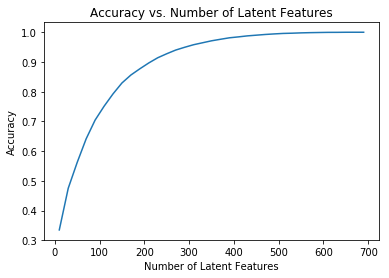

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    # Create user-item matrix of the training dataframe
    user_item_train=create_user_item_matrix(df_train)  
    
    # Create user-item matrix of the testing dataframe
    user_item_test=create_user_item_matrix(df_test)
    
    # Create array with all of the test user ids
    test_idx=np.array(user_item_test.index)
    
    # Create array with all of the test article ids
    test_arts=np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
# How many users can we make predictions for in the test set?

20

In [49]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?

662

In [50]:
# How many articles can we make predictions for in the test set?
user_item_test.shape[1]

574

There are 574 columns in the test set. It is possible to make predictions for all articles.

In [51]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem
user_item_test.mean().isnull().value_counts()

False    574
dtype: int64

There is no column which contains only zeros. Thus, there are 0 for which no predictions can be made.

In [52]:
# Note: The test function in project_tests.py contains an error 
# since the questions in the dictionary differ from the questions here.
# Thus, this cell has been adapted to it.
# However, the result message still makes no sense (It is about movies).

# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [53]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

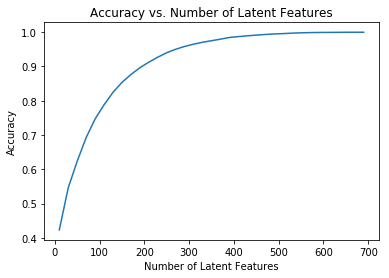

In [54]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

In my opinion and with my own experience with recommendations I got on different websites, the user must be asked. To rate an article e.g. the relevancy for a specific topic would be a kind of question. The way to use just the information whether articles have been seen is from my point of view challenging in order to make good recommendations.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0